<a href="https://colab.research.google.com/github/NiloofarSoltani-2/Smart-Water-Management/blob/main/smart_water_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Introduction

## Data Structure

In [2]:
df = pd.read_csv('/content/sample_data/aquifers_fe.csv')
df.shape

(8154, 6)

In [4]:
print (df.head())

            mean_rainfall  mean_temp  actual_depth  actual_volume  \
date                                                                
1998-01-04       0.415556     6.6250      -6.08026   -8019.271158   
1998-01-05       2.054444     6.0750      -6.06452   -7956.571285   
1998-01-06       0.921111     9.0875      -6.15706   -7715.808854   
1998-01-07       0.878889    12.3250      -6.10774   -7731.378766   
1998-01-08       0.908889    12.6500      -6.05310   -7812.676449   

            actual_hydrometry  
date                           
1998-01-04          -0.083056  
1998-01-05          -0.104167  
1998-01-06           0.011944  
1998-01-07          -0.008611  
1998-01-08          -0.072222  


In [12]:
df. columns

Index(['mean_rainfall', 'mean_temp', 'actual_depth', 'actual_volume',
       'actual_hydrometry'],
      dtype='object')

In [6]:
df.isnull().sum()

,0
mean_rainfall,0
mean_temp,0
actual_depth,0
actual_volume,0
actual_hydrometry,0


## Cleaning

In [ ]:
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [7]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)


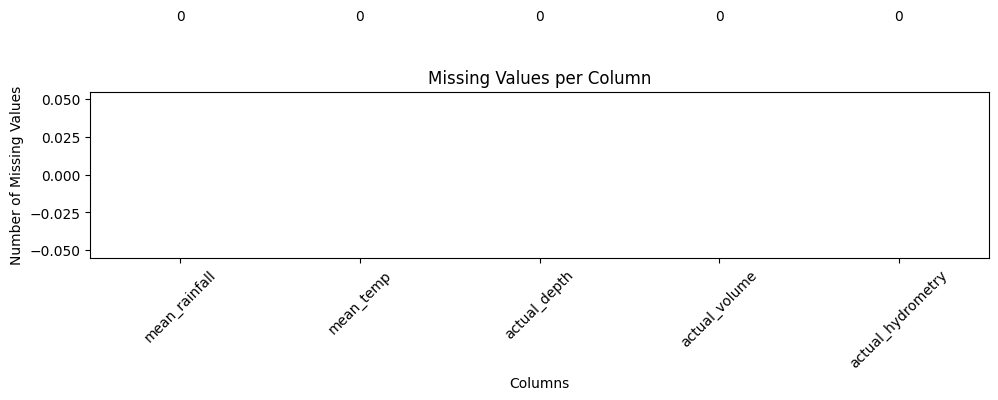

In [9]:
# Calculate missing values
missing_counts = df.isnull().sum()

# Plot
plt.figure(figsize=(10, 5))
missing_counts.plot(kind='bar', color='green')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')

# Annotate bars with value
for i, v in enumerate(missing_counts):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
